In [11]:
import numpy as np
from tqdm import tqdm
from numba import jit,njit
import pandas as pd
import json
import matplotlib.pyplot as plt

In [12]:
global N_total

def damage_Rate(a,b,time):
    return a*(1 + b*time)

def repair_Rate(r,s,time):
    return r*(1 - s*time)

def mortality_Rate(mu, C, N_individual):
    return mu*(N_individual/N_total)**C

def modelo_constitutivo(a,b,r,s, mu, C, time, N_individual):

    damare_Rate_propensity = damage_Rate(a,b,time)
    Repair_Rate_propensity = repair_Rate(r,s,time)
    Mortality_Rate_propensity = mortality_Rate(mu, C, N_individual)
    return damare_Rate_propensity, Repair_Rate_propensity, Mortality_Rate_propensity, 


100%|██████████| 1000/1000 [00:00<00:00, 3219.69it/s]


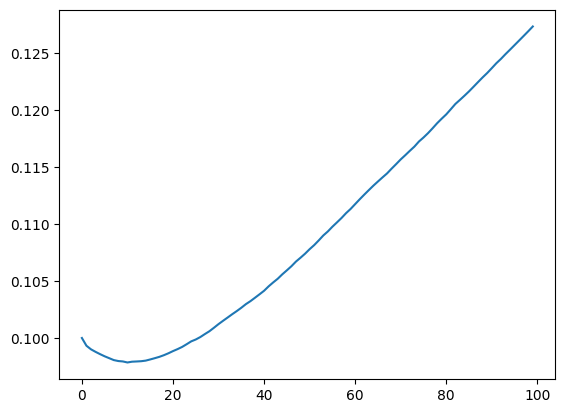

In [35]:
def Gillespie(trp0,tmax):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en el individuo. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """

    time , N_individual, died  =trp0 

    a = 0.05
    b = 0.09
    r = 0.1
    s = 0.0
    C = 2.87
    mu = 1

    while time < tmax and not died:
        s_1, s_2, s_3  =  modelo_constitutivo(a,b,r,s, mu, C, time, N_individual)
        S_T = s_1 + s_2 + s_3 
        tasa_maxima = mu + a + r

        if np.random.rand() < np.abs(S_T-tasa_maxima)/tasa_maxima:
            τ = (-1/tasa_maxima)*np.log(np.random.rand())
            x = np.random.rand()
            time+=τ

            if x <= (s_1)/S_T:
                N_individual += 1

            elif x<= (s_1 + s_2)/S_T:
                N_individual -= 1
            
            else: 
                died = True
                return np.array([time, N_individual, died ]) 
        
    return np.array([time, N_individual, died ]) 

def Estado_celula(X0,tiempos):

    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
    
    return X

N_total = 1000
x0 = np.array([0., N_total*0.1, 0.])

num_cel = 1000 #número de células 
celulas = np.array([Estado_celula(x0,np.arange(0.,100.,1.)) for i in tqdm(range(num_cel))])

suma = np.nansum(celulas[:, :, 1], axis=0)

# Calcula la longitud sin contar los NaN
longitud_valida = np.sum(~np.isnan(celulas[:, :, 1]), axis=0)

# Calcula el promedio ignorando los NaN
promedio_curva_frailty_index = np.divide(suma, longitud_valida, out=np.zeros_like(suma), where=longitud_valida != 0)

plt.plot(promedio_curva_frailty_index/N_total)
